In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.externals import joblib

plt.style.use('ggplot')

In [2]:
def predict_proba_matrix(trained_model_list,df):
    low_band = 0.05
    high_band = 0.5
    data = df.reset_index(drop=True)
    verify_df =pd.DataFrame()
    extend_feature = []
    with atecml.data.timer('Validation.....'):
        for idx in tqdm(range(len(trained_model_list))):
            clf = trained_model_list[idx]
            model_params = train_model[idx].split('__')
            f_idx = int(model_params[3])
            select_feature = feature_list[f_idx]
            y_predict = clf.predict(data[select_feature])
            if (model_params[1] == 'Fraud'):
                verify_df['n'+str(idx)] = abs(y_predict)
            else:
                verify_df['n'+str(idx)] = abs(1- y_predict)
            ext = pd.DataFrame(clf.apply(data[select_feature])).T
            extend_feature.append(ext)
                
    v_var=verify_df.var(axis=1)
    v_mean=verify_df.mean(axis=1)
    v_skew=verify_df.skew(axis=1)
    v_kurt=verify_df.T.kurt(axis=1)
    verify_df['var'] = v_var
    verify_df['mean'] = v_mean
    verify_df['skew'] = v_skew
    verify_df['kurt'] = v_kurt
    
    ext_df = pd.concat(extend_feature,ignore_index=True)
    #ext_df = pd.concat([ext_df_tmp.T,data['id']],axis=1)
            
    result = pd.concat([verify_df,data['id']],axis=1)
    filter_id_list = list(result[(result['mean'] > low_band) & (result['mean'] < high_band)]['id'])
    residual_df = data[data['id'].isin(filter_id_list)].reset_index(drop=True)
    
    return result,residual_df,ext_df

In [3]:
#Loading Data....
data = atecml.data.load_train()
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-15')
val_df = atecml.data.filter_date(data,start_date='2017-10-16',end_date='2018-10-15')

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]

#Loading Data....
data = atecml.data.load_train()
predictors = [x for x in data.columns if x not in atecml.data.NOT_FEATURE_SUM]


feature_tree_num = 5
train_model =[]
target_list = ['Normal','Fraud']
#target_list = ['Normal']
#target_list = ['Fraud']

for idx in range(0,1):
    for item in ['dart','gbdt','rf']:
        for feature_grp_idx in range(0,feature_tree_num):
            for target in target_list:
                train_id = item + '__'+target +'__'+str(idx) +'__' + str(feature_grp_idx)
                train_model.append(train_id)

                
def model_load(model_name):
    model_cache_name = './'+model_name+'.model'
    if (os.path.exists(model_cache_name)):
        clf = joblib.load(model_cache_name)
    else:
        print('ERROR...............')
    return clf


if (os.path.exists('./feature_list.dat')):
    print('Load Feature List from persistant store...')
    feature_list = joblib.load('./feature_list.dat')
else:
    print('Error: Feature Cache File missing...')


trained_model_list =[]
with atecml.data.timer('Classification: Model Training'):
    for train_id in tqdm(range(len(train_model))):
        fit_model = model_load(train_model[train_id])
        trained_model_list.append(fit_model)




  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Load Feature List from persistant store...
[2018-06-29 14:59:41][Classification: Model Training] Begin ...


100%|██████████| 30/30 [00:01<00:00, 19.49it/s]

[2018-06-29 14:59:42][Classification: Model Training] End   ...[Elapsed: 1.55s]


In [4]:
verify_df = atecml.data.load_train()
verify_data = atecml.data.filter_date(verify_df,start_date='2017-10-16',end_date='2018-10-15')
result,res,ext = predict_proba_matrix(trained_model_list,verify_df)

  0%|          | 0/30 [00:00<?, ?it/s]

[2018-06-29 14:59:53][Validation.....] Begin ...


100%|██████████| 30/30 [08:39<00:00, 16.52s/it]


[2018-06-29 15:08:32][Validation.....] End   ...[Elapsed: 519.30s]


In [ ]:
df2 = pd.concat([ext.T,data],axis=1)

In [ ]:
rename_dict = {}
for idx in range(0,12000):
    rename_dict[idx] = "n" + str(idx)
df2.rename(columns=rename_dict,inplace=True)    
df2.to_pickle('./ext.df')

In [ ]:
a,b,c=atecml.data.accuracy_validation(verify_df['Fraud'],result['mean'])

62304
4714
Ant-Score: 0.7839626644039033


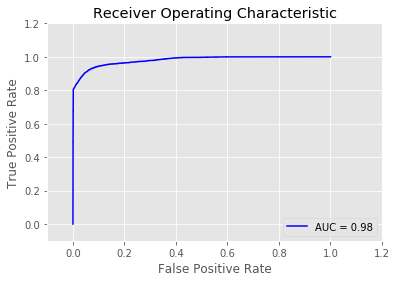

In [14]:
low_band=0.05
high_band = 0.5

filter_id_list = list(result[(result['mean'] > low_band) & (result['mean'] < high_band)]['id'])
print(len(filter_id_list))

temp_df = verify_df[~verify_df['id'].isin(filter_id_list)].reset_index(drop=True)
temp_df_proba = result[~result['id'].isin(filter_id_list)].reset_index(drop=True)
print(len(temp_df[temp_df['Fraud']==1]['id']))
a,b,c=atecml.data.accuracy_validation(temp_df['Fraud'],temp_df_proba['mean'])

In [ ]:
res_df = verify_df[verify_df['id'].isin(filter_id_list)].reset_index(drop=True)
res_df_proba = result[result['id'].isin(filter_id_list)].reset_index(drop=True)
a,b,c=atecml.data.accuracy_validation(res_df['Fraud'],res_df_proba['mean'])

In [ ]:
res_train = pd.concat([result[result['id'].isin(list(res['id']))].reset_index(drop=True),res],axis=1)
res_train.to_pickle('./res.dat')

In [ ]:
a =set(res_train[res_train['Fraud']==1]['NaN_LIST'])
b =set(res_train['NaN_LIST'])

In [ ]:
idx = 1
clf = trained_model_list[idx]
model_params = train_model[idx].split('__')
f_idx = int(model_params[3])
select_feature = feature_list[f_idx]
a1 = pd.DataFrame(clf.apply(data[select_feature]))

In [ ]:
idx = 2
clf = trained_model_list[idx]
model_params = train_model[idx].split('__')
f_idx = int(model_params[3])
select_feature = feature_list[f_idx]
a2 = pd.DataFrame(clf.apply(data[select_feature]))

In [ ]:
pd.concat([a1.T,a2.T],ignore_index=True)

In [ ]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error', model_type='gbdt',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=50, categorical_features=None):
    
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'objective': 'regression',
        'use_missing' : 'true',
        'learning_rate': 0.05,
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.9,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 0.1,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': 0,
        #'n_estimators' : 600,
        'metric':{'l2', 'auc'}
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in atecml.data.CATE_FEATURE_LIST):
            categorical.append(item)
            
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.12,
        } 
    else:
        params = {
            'scale_pos_weight' : 8,
        }
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        model_type='rf',
                        objective='regression', 
                        #metrics ='binary',
                        metrics={'auc'},
                        early_stopping_rounds=1000, 
                        verbose_eval=50, 
                        num_boost_round=10000, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [ ]:
data = pd.read_pickle('./res.dat')
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-13')
val_df = atecml.data.filter_date(data,start_date='2017-10-14',end_date='2018-10-15')
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]


In [ ]:
import lightgbm as lgb

model_pos,score_pos = model_validation(train_df,val_df,predictors,'Normal',{})
model_neg,score_neg = model_validation(train_df,val_df,predictors,'Fraud',{})

In [ ]:
idx = 1
clf = trained_model_list[idx]
model_params = train_model[idx].split('__')
f_idx = int(model_params[3])
select_feature = feature_list[f_idx]


In [ ]:
sklearn.cluster.KMeans(n_clusters=8,
     init='k-means++', 
    n_init=10, 
    max_iter=300, 
    tol=0.0001, 
    precompute_distances='auto', 
    verbose=0, 
    random_state=None, 
    copy_x=True, 
    n_jobs=1, 
    algorithm='auto'
    )

In [ ]:
res_feature_list = []
for idx in range(0,60):
    res_feature_list.append('n'+str(idx))
    

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_n = 5
estimator = KMeans(n_clusters=cluster_n,max_iter=50000,n_jobs=-1,algorithm='elkan')
estimator.fit(res_train[res_feature_list])

In [ ]:
neg_rate = len(res_train[res_train['Fraud']==1])/len(res_train)

In [ ]:
neg_rate

In [ ]:
res_train['cluster'] = estimator.labels_ 

In [ ]:
cluster_ratio = []
for idx in range(0,cluster_n):
    ratio = res_train[res_train['cluster'] ==idx]['Fraud'].sum() /res_train[res_train['cluster'] ==idx]['Fraud'].count() / neg_rate
    cluster_ratio.append(ratio)

In [ ]:
cluster_ratio

In [ ]:
foo = res_train.index.map(lambda x : res_train['mean'][x]*cluster_ratio[res_train['cluster'][x]])

In [ ]:
a,b,c=atecml.data.accuracy_validation(res_df['Fraud'],foo)

In [ ]:
res_train

In [ ]:
temp_df = verify_data[verify_data['id'].isin(filter_id_list)].reset_index(drop=True)
temp_df_proba = result[result['id'].isin(filter_id_list)].reset_index(drop=True)
a,b,c=atecml.data.accuracy_validation(temp_df['Fraud'],temp_df_proba['mean'])

In [ ]:
low_band = 0.3
high_band = 0.7

filter_id_list = list(result[(result['mean'] > low_band) & (result['mean'] < high_band)]['id'])

temp_df = verify_data[~verify_data['id'].isin(filter_id_list)].reset_index(drop=True)
temp_df_proba = result[~result['id'].isin(filter_id_list)].reset_index(drop=True)
a,b,c=atecml.data.accuracy_validation(temp_df['Fraud'],temp_df_proba['mean'])

In [ ]:
temp_df = verify_data[verify_data['id'].isin(filter_id_list)].reset_index(drop=True)
temp_df_proba = result[result['id'].isin(filter_id_list)].reset_index(drop=True)
a,b,c=atecml.data.accuracy_validation(temp_df['Fraud'],temp_df_proba['mean'])

In [ ]:
a,b,c=atecml.data.accuracy_validation(verify_data['Fraud'],result['mean'])

In [ ]:
verify_df = atecml.data.load_train()
verify_data = atecml.data.filter_date(verify_df,start_date='2017-10-16',end_date='2018-10-15')
verify_data.reset_index(drop=True,inplace=True)

In [ ]:
verify_df =pd.DataFrame()
with atecml.data.timer('Validation: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        model_params = train_model[idx].split('__')
        f_idx = int(model_params[3])
        select_feature = feature_list[f_idx]
        y_predict = clf.predict(verify_data[select_feature])
        if (model_params[1] == 'Fraud'):
            verify_df[idx] = abs(y_predict)
        else:
            verify_df[idx] = abs(1- y_predict)

In [ ]:
verify_proba_4dnn = pd.concat([verify_df,verify_data['Fraud']],axis=1)
verify_proba_4dnn.to_pickle('./verify_proba.dat')
verify_df['mean']=verify_df.T.mean()

In [ ]:
a,b,c=atecml.data.accuracy_validation(verify_data['Fraud'],verify_df['mean'])

In [ ]:
#build Train_Proba Matrix for DNN:
train_df = atecml.data.load_train()
train_df = atecml.data.filter_date(train_df,start_date='2016-10-16',end_date='2017-10-15')
train_proba =pd.DataFrame()
with atecml.data.timer('Regenerate: Train Proba.....'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        model_params = train_model[idx].split('__')
        f_idx = int(model_params[3])
        select_feature = feature_list[f_idx]
        
        y_predict = clf.predict(train_df[select_feature])
        if (model_params[1] == 'Fraud'):
            train_proba[idx] = y_predict
        else:
            train_proba[idx] = 1 - y_predict   

In [ ]:
train_proba_4dnn = pd.concat([train_proba,train_df['Fraud']],axis=1)
train_proba_4dnn.to_pickle('./train_proba.dat')

In [ ]:
test_df = atecml.data.load_test()
predict_df =pd.DataFrame()
with atecml.data.timer('Validation: Modelfit'):
    for idx in tqdm(range(len(trained_model_list))):
        clf = trained_model_list[idx]
        model_params = train_model[idx].split('__')
        f_idx = int(model_params[3])
        select_feature = feature_list[f_idx]
        
        
        y_predict = clf.predict(test_df[select_feature])
        if (model_params[1] == 'Fraud'):
            predict_df[idx] = y_predict
        else:
            predict_df[idx] = 1 - y_predict  
            
predict_df.to_pickle('./test_proba.dat')            

In [ ]:
predict_df['mean']=predict_df.T.mean()

In [ ]:
result = pd.DataFrame()
result['id'] = test_df['id']
result['score'] =1- predict_df['mean']


In [ ]:
result['score'] = result['score'].apply(lambda x: x if (x >0) else 0)
result.to_csv('./submit_2018_06_27_7.csv',index=False)